# Language Model Reports

Since my local machine does not have GPU support and thus can't perform many model training and evaluation tasks in a reasonable amount of time, I have created a script `evaluation.lua` in this repository which generates reports on a language model and serializes them in JSON. This notebook will consume these reports and explore them. It will also include some information about the models these reports were made for that is not included in the serialized report.

In [48]:
# load some requirements
import json
import matplotlib.pyplot as plt
with open('reports/threelayermodelreport.json', 'r') as f:
    three_layer_report = json.loads(f.read())
with open('reports/newcudareport.json', 'r') as f:
    two_layer_report = json.loads(f.read())

# 25K Deeper, Thinner Network

I created a model with 3 LSTM layers, a dropout of 0.2, and a hidden size of 150. Here we can look at it's structure:

```
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> output]
  (1): nn.LookupTable
  (2): nn.LSTM(100 -> 150)
  (3): nn.Dropout(0.150000)
  (4): nn.LSTM(150 -> 150)
  (5): nn.Dropout(0.150000)
  (6): nn.LSTM(150 -> 150)
  (7): nn.Dropout(0.150000)
  (8): nn.DynamicView
  (9): nn.Linear(150 -> 25000)
  (10): nn.LogSoftMax
}
```

### Losses on the Datasets

I have created 3 datasets, built from the Google Billion Words data set. I trained on a version of the `train_small` data set with a reduced vocabulary of 25000, in batches of size 50, with a sequence length cut off of 30. I did not tune any hyper parameters with the validation set, but this could be future work. There is also a small test set.

In [49]:
# print out the losses from the report
print 'Training set loss:', three_layer_report['train_loss']
print 'Validation set loss:', three_layer_report['valid_loss']
print 'Test set loss:', three_layer_report['test_loss']

Training set loss: 6.56984843539
Validation set loss: 6.57084906608
Test set loss: 6.5590656137


### Loss Versus Sequence Length

We can examine the relationship between loss and sequence length. We can expect higher losses with increasing sequence length as more information must be remembered by the model as it generates, and the model is only trained on examples of sequence length 30 or less. We can generate a scatter plot of batch loss v. sequence length of batch (all batches are same size):

In [50]:
# function for turning report data into scatter plot
def scatterize_batch_loss(report_batch_loss):
    x = []
    y = []
    for i, v in enumerate(report_batch_loss):
        if i > 50:
            break # We'll only consider ones of length 50 and below to get a better view of the data in the chart.
        if isinstance(v, list):
            x.extend([i + 1 for j in v]) # same batch size for all losses in v
            y.extend([j for j in v])
        else:
            if v is not None:
                x.append(i)
                y.append(v)
    return x, y

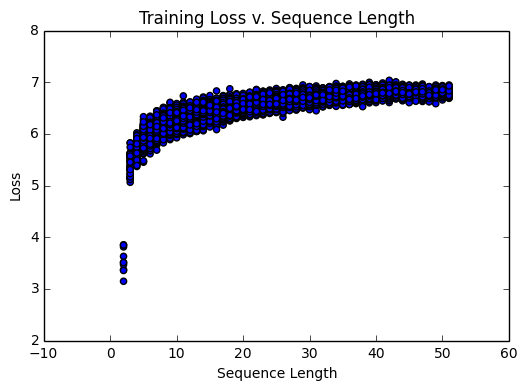

In [51]:
%matplotlib inline
x, y = scatterize_batch_loss(three_layer_report['train_batch_loss'])
plt.scatter(x, y)
plt.title('Training Loss v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.show()

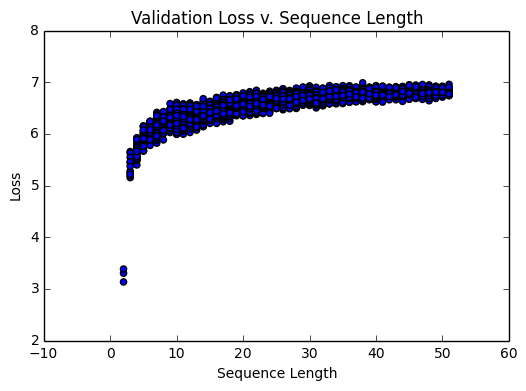

In [52]:
%matplotlib inline
x, y = scatterize_batch_loss(three_layer_report['valid_batch_loss'])
plt.scatter(x, y)
plt.title('Validation Loss v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.show()

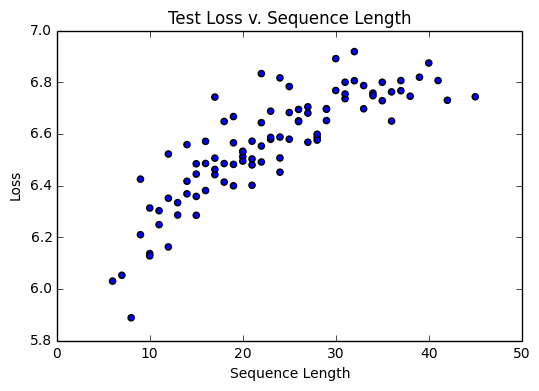

In [53]:
%matplotlib inline
x, y = scatterize_batch_loss(three_layer_report['test_batch_loss'])
plt.scatter(x, y)
plt.title('Test Loss v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.show()

## Generation Samples

We can also look at examples of how it generates text. Below are side by side comparisons of the labels from the training/validation/test set and the sentence the model generated. A Special `<G>` token will be placed in the generated sequence to illustrate where the model's input ends and it's generation begins.

In [54]:
def print_sample(sample):
    seq = sample['generated'].split(' ')
    seq.insert(sample['supplied_length'] + 1, '<G>')
    gold = sample['gold'].split(' ')
    gold.insert(sample['supplied_length'], '<G>')
    print('Gend: ' + ' '.join(seq))
    print('True: ' + seq[1] + ' ' + ' '.join(gold) + '\n')
    

#### Training Set Generation Examples

In [55]:
for sample in three_layer_report['train_samples'][0:5]:
    print_sample(sample)
    

Gend:  Why were you motivated to write <G> the . </S>
True: Why  were you motivated to write <G> this book ? </S>

Gend:  And check out <G> , the <UNK> . </S>
True: And  check out <G> our favorite <UNK> <UNK> of <UNK> . </S>

Gend:  CNN : You 're a newcomer to this genre <G> . </S>
True: CNN  : You 're a newcomer to this genre <G> . </S>

Gend:  Some were relieved <G> </S>
True: Some  were relieved <G> . </S>

Gend:  No one on the bus <G> the . </S>
True: No  one on the bus <G> was injured . </S>



In [56]:
for sample in three_layer_report['valid_samples'][0:5]:
    print_sample(sample)
    

Gend:  Out here no <G> , , . said </S>
True: Out  here no <G> one can hear them scream . </S>

Gend:  State Senator <G> </S>
True: State  Senator <G> Yvonne Miller . </S>

Gend:  It 's no wonder <G> , . </S>
True: It  's no wonder <G> he was a bit weary . </S>

Gend:  The <UNK> study <G> <UNK> <UNK> <UNK> </S>
True: The  <UNK> study <G> tried to do that . </S>

Gend:  Points to <G> <UNK> <UNK> <UNK> . <UNK> </S>
True: Points  to <G> McCain . </S>



In [57]:
for sample in three_layer_report['test_samples'][0:5]:
    print_sample(sample)
    

Gend:  How about a sibling or family friend ? <G> </S>
True: How  about a sibling or family friend ? <G> </S>

Gend:  Can you explain , <G> </S>
True: Can  you explain , <G> please ? </S>

Gend:  My credit card was invalid <G> , . </S>
True: My  credit card was invalid <G> , the representative said . </S>

Gend:  Two others sustained broken bones <G> the . </S>
True: Two  others sustained broken bones <G> . </S>

Gend:  Alison Left 's maiden name was of no <G> the . </S>
True: Alison  Left 's maiden name was of no <G> consequence . </S>



### Conclusion

While we can see this model has the expected distribution of losses over each set, and does not over fit, it doesn't generate coherent conclusions to the input sentence fragments. In terms of generation quality, it leaves a lot to be desired.

# 25K Shallower, Broader Network

I created a model with 3 LSTM layers, a dropout of 0.2, and a hidden size of 150. Here we can look at it's structure:

```
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> output]
  (1): nn.LookupTable
  (2): nn.LSTM(100 -> 300)
  (3): nn.Dropout(0.150000)
  (4): nn.LSTM(300 -> 300)
  (5): nn.Dropout(0.150000)
  (6): nn.DynamicView
  (7): nn.Linear(300 -> 25000)
  (8): nn.LogSoftMax
}
```

Notably, this one is a layer shallower and has a larger hidden size, with slightly reduced dropout. While it is not captured in the report, this model converged to it's final loss more quickly than the previous model.

### Losses on the Datasets

This model experienced a reduced loss across each of the datasets:


In [58]:
# print out the losses from the report
print 'Training set loss:', two_layer_report['train_loss']
print 'Validation set loss:', two_layer_report['valid_loss']
print 'Test set loss:', two_layer_report['test_loss']

Training set loss: 6.09166994846
Validation set loss: 6.09586348902
Test set loss: 6.07624920466


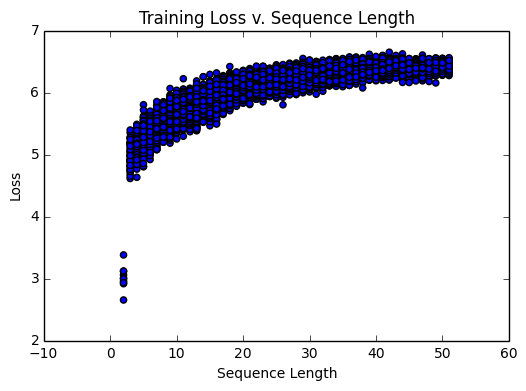

In [59]:
%matplotlib inline
x, y = scatterize_batch_loss(two_layer_report['train_batch_loss'])
plt.scatter(x, y)
plt.title('Training Loss v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.show()

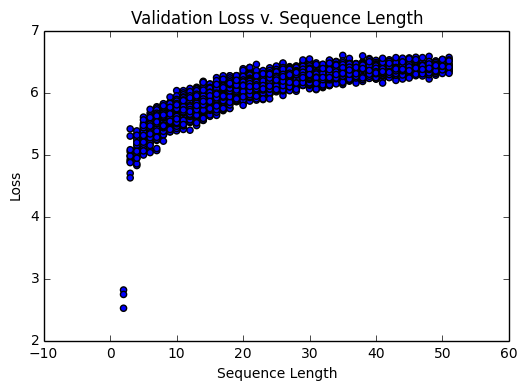

In [60]:
%matplotlib inline
x, y = scatterize_batch_loss(two_layer_report['valid_batch_loss'])
plt.scatter(x, y)
plt.title('Validation Loss v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.show()

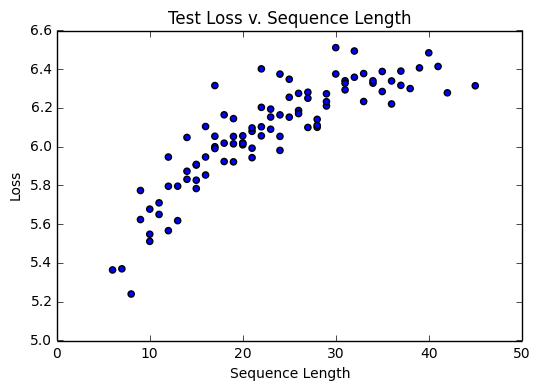

In [61]:
%matplotlib inline
x, y = scatterize_batch_loss(two_layer_report['test_batch_loss'])
plt.scatter(x, y)
plt.title('Test Loss v. Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Loss')
plt.show()

Notably, this model has a loss below 6 for sequences that are ~10 words or less.

## Generation Samples

We can also look at examples of how it generates text. Below are side by side comparisons of the labels from the training/validation/test set and the sentence the model generated. A Special `<G>` token will be placed in the generated sequence to illustrate where the model's input ends and it's generation begins. I chose to look at only short sequences, as the models each have lower loss for these, and might stand a chance of answering correctly.

In [62]:
for sample in two_layer_report['train_samples'][0:5]:
    print_sample(sample)

Gend:  Analysts surveyed by Bloomberg estimated 79 <G> <UNK> . </S>
True: Analysts  surveyed by Bloomberg estimated 79 <G> cents . </S>

Gend:  He said none <G> the <UNK> . </S>
True: He  said none <G> was <UNK> . </S>

Gend:  It <G> was was not guardian.co.uk . </S>
True: It  <G> was hugely inspirational . </S>

Gend:  On his feet : <UNK> <UNK> . <G> </S>
True: On  his feet : <UNK> <UNK> . <G> </S>

Gend:  I have a 12 year old daughter . <G> </S>
True: I  have a 12 year old daughter . <G> </S>



In [63]:
for sample in two_layer_report['valid_samples'][0:5]:
    print_sample(sample)

Gend:  See <G> , " said <UNK> . </S>
True: See  <G> an ad on the screen . </S>

Gend:  Or <UNK> <UNK> . <G> </S>
True: Or  <UNK> <UNK> . <G> </S>

Gend:  On Wednesday , the GAO <G> , the <UNK> <UNK> <UNK> </S>
True: On  Wednesday , the GAO <G> praised these initial steps . </S>

Gend:  Simple , fair , and representative of people <G> <UNK> . </S>
True: Simple  , fair , and representative of people <G> ! </S>

Gend:  <UNK> <G> </S>
True: <UNK>  <G> and <UNK> is the important flavour here . </S>



In [64]:
for sample in two_layer_report['test_samples'][0:5]:
    print_sample(sample)

Gend:  Thomas <UNK> , <G> <UNK> <UNK> <UNK> <UNK> <UNK> . </S>
True: Thomas  <UNK> , <G> whose Sept . </S>

Gend:  27 / PRNewswire-FirstCall / -- <UNK> Pharmaceuticals , Inc . <G> </S>
True: 27  / PRNewswire-FirstCall / -- <UNK> Pharmaceuticals , Inc . <G> </S>

Gend:  " It <G> <UNK> <UNK> , " " said <UNK> " <UNK> .
True: "  It <G> was in the main street . </S>

Gend:  It has always <UNK> trends <G> " . </S>
True: It  has always <UNK> trends <G> . </S>

Gend:  Gates said the <G> <UNK> <UNK> . </S>
True: Gates  said the <G> energy industry needs diversity and competition . </S>



### Conclusion

This model has lower loss and doesn't seem to make quite as many gibberish mistakes in generation (double periods, long strings of `<UNK>`, etc.) This is perhaps too small of a sample to make a real conclusion though. Like the previous model, it tends to favor abrupt endings, as it likely is being punished less for only getting a couple tokens wrong instead of a long sequence of wrong answers. It is also leaves an idea hanging, ending sentences with "the", etc.